In [1]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu

import matplotlib.pyplot as plt
from matplotlib import gridspec 
import seaborn as sns
sns.set_style('white')
%matplotlib inline

import os
import sys
sys.path.append('/cellar/users/andreabc/scripts/')

### Global variables

In [2]:
MSS = 'MSS_only' # MSS_only, MSS_and_MSI

mss_patients = np.loadtxt('/cellar/users/andreabc/Data/b2m/mss_tcga_patients.txt', dtype=str)

### Load patients

In [3]:
# removed sex-specific cancers for sex-specific analyses
print('Loading confident {} patients with removed sex-specific cancers '.format(MSS))
confident_patients_I_rm_sex_specific = pd.read_csv('/cellar/users/andreabc/Data/hla_sex/generated_data/confident_patient_I.age_sex_disease.{}.remove_sex_specific.txt'.format(MSS), sep='\t', index_col=0)
confident_patients_II_rm_sex_specific = pd.read_csv('/cellar/users/andreabc/Data/hla_sex/generated_data/confident_patient_II.age_sex_disease.{}.remove_sex_specific.txt'.format(MSS), sep='\t', index_col=0)

print('{} confident MHC-I, {} confident MHC-II'.format(len(set(confident_patients_I_rm_sex_specific.index)), 
                                                       len(set(confident_patients_II_rm_sex_specific.index))))
confident_patients_I_rm_sex_specific.head(2)

Loading confident MSS_only patients with removed sex-specific cancers 
2554 confident MHC-I, 2681 confident MHC-II


,scores,disease,age,sex,age_categorical
TCGA-85-8580,0.120879,LUSC,52.0,female,younger
TCGA-IB-AAUM,1.249676,PAAD,76.0,male,older


In [4]:
# removed sex-specific cancers for sex-specific analyses
print('Loading confident {} patients with kept sex-specific cancers'.format(MSS))
confident_patients_I_kept_sex_specific = pd.read_csv('/cellar/users/andreabc/Data/hla_sex/generated_data/confident_patient_I.age_sex_disease.{}.kept_sex_specific.txt'.format(MSS), sep='\t', index_col=0)
confident_patients_II_kept_sex_specific = pd.read_csv('/cellar/users/andreabc/Data/hla_sex/generated_data/confident_patient_II.age_sex_disease.{}.kept_sex_specific.txt'.format(MSS), sep='\t', index_col=0)

# set age threshold
young_thresh = 52 # 30th percentile: 52, 40th: 57
old_thresh = 68   # 70th percentile: 68, 60th: 65

confident_patients_I_kept_sex_specific['age_categorical_3070'] = pd.cut(confident_patients_I_kept_sex_specific['age'], [0, young_thresh, old_thresh, confident_patients_I_kept_sex_specific['age'].max()], labels=['younger', 'middle', 'older'])
confident_patients_II_kept_sex_specific['age_categorical_3070'] = pd.cut(confident_patients_II_kept_sex_specific['age'], [0, young_thresh, old_thresh, confident_patients_II_kept_sex_specific['age'].max()], labels=['younger', 'middle', 'older'])

confident_patients_I_kept_sex_specific = confident_patients_I_kept_sex_specific[confident_patients_I_kept_sex_specific['age_categorical_3070']!='middle']
confident_patients_II_kept_sex_specific = confident_patients_II_kept_sex_specific[confident_patients_II_kept_sex_specific['age_categorical_3070']!='middle']

print('{} confident MHC-I, {} confident MHC-II'.format(len(set(confident_patients_I_kept_sex_specific.index)), 
                                                       len(set(confident_patients_II_kept_sex_specific.index))))
confident_patients_I_kept_sex_specific.head()

Loading confident MSS_only patients with kept sex-specific cancers
1881 confident MHC-I, 1834 confident MHC-II


,scores,disease,age,sex,age_categorical,age_categorical_3070
TCGA-85-8580,0.120879,LUSC,52.0,female,younger,younger
TCGA-IB-AAUM,1.249676,PAAD,76.0,male,older,older
TCGA-DU-7008,1.559341,LGG,41.0,female,younger,younger
TCGA-DU-7008,2.249268,LGG,41.0,female,younger,younger
TCGA-D7-6815,6.717888,STAD,70.0,female,older,older


### Load data

In [5]:
# sex analysis
affinity_I_sex_df = pd.read_csv('/cellar/users/andreabc/Data/TCGA/all.driver_mut.class_i.affinities', sep='\t', index_col=0)
affinity_I_sex_df = affinity_I_sex_df[affinity_I_sex_df.index.isin(confident_patients_I_rm_sex_specific.index)]

affinity_II_sex_df = pd.read_csv('/cellar/users/andreabc/Data/TCGA/all.driver_mut.class_ii.affinities', sep='\t', index_col=0)
affinity_II_sex_df = affinity_II_sex_df[affinity_II_sex_df.index.isin(confident_patients_II_rm_sex_specific.index)]

In [6]:
# age analysis
affinity_I_age_df = pd.read_csv('/cellar/users/andreabc/Data/TCGA/all.driver_mut.class_i.affinities', sep='\t', index_col=0)
affinity_I_age_df = affinity_I_age_df[affinity_I_age_df.index.isin(confident_patients_I_kept_sex_specific.index)]

affinity_II_age_df = pd.read_csv('/cellar/users/andreabc/Data/TCGA/all.driver_mut.class_ii.affinities', sep='\t', index_col=0)
affinity_II_age_df = affinity_II_age_df[affinity_II_age_df.index.isin(confident_patients_II_kept_sex_specific.index)]

In [7]:
# # save patients
# np.savetxt('/cellar/users/andreabc/Data/hla_sex/clean_data/mhcI.sex.patients.txt', list(set(affinity_I_sex_df.index.values)), delimiter='\n', fmt='%s')
# np.savetxt('/cellar/users/andreabc/Data/hla_sex/clean_data/mhcII.sex.patients.txt', list(set(affinity_II_sex_df.index.values)), delimiter='\n', fmt='%s')
# np.savetxt('/cellar/users/andreabc/Data/hla_sex/clean_data/mhcI.age.patients.txt', list(set(affinity_I_age_df.index.values)), delimiter='\n', fmt='%s')
# np.savetxt('/cellar/users/andreabc/Data/hla_sex/clean_data/mhcII.age.patients.txt', list(set(affinity_II_age_df.index.values)), delimiter='\n', fmt='%s')

### Plots

Saving to /cellar/users/andreabc/Data/hla_sex/figures/supplementary/S3.sex_age_PHBR.MSS_only.violin.pdf


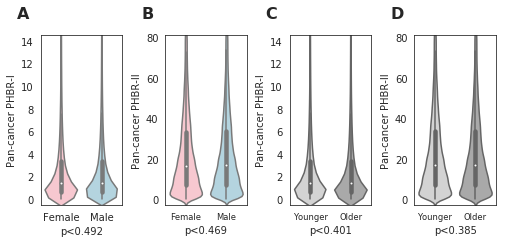

In [10]:
plt.figure(figsize=(7,3))

# A - All PHBR-I scores - sex
plt.subplot(1,4,1)
data = affinity_I_sex_df.join(confident_patients_I_rm_sex_specific[['sex']]).reset_index()
data = pd.melt(data, id_vars=['sex', 'index']).drop_duplicates()
p = mannwhitneyu(data[data['sex']=='female'].index.values, data[data['sex']=='male'].index.values).pvalue
ax = sns.violinplot(x='sex', y='value', data=data, order=['female', 'male'], palette=['pink', 'lightblue'])
plt.xlabel('p<{:.3}'.format(p)), plt.ylabel('Pan-cancer PHBR-I')
plt.xticks([0,1], ['Female', 'Male'])#, fontsize='small')
plt.ylim(ymin=-0.5, ymax=14.5)
plt.text(-0.3, 1.1, 'A', transform=ax.transAxes, fontsize=16, weight='bold')


# B - All PHBR-II scores - sex
plt.subplot(1,4,2)
data = affinity_II_sex_df.join(confident_patients_II_rm_sex_specific[['sex']]).reset_index()
data = pd.melt(data, id_vars=['sex', 'index']).drop_duplicates()
p = mannwhitneyu(data[data['sex']=='female'].index.values, data[data['sex']=='male'].index.values).pvalue
ax = sns.violinplot(x='sex', y='value', data=data, order=['female', 'male'], palette=['pink', 'lightblue'])
plt.xlabel('p<{:.3}'.format(p)), plt.ylabel('Pan-cancer PHBR-II')
plt.xticks([0,1], ['Female', 'Male'], fontsize='small')
plt.ylim(ymin=-2.7,ymax=81)
plt.text(-0.3, 1.1, 'B', transform=ax.transAxes, fontsize=16,  weight='bold')


# C - All PHBR-I scores - age
plt.subplot(1,4,3)
data = affinity_I_age_df.join(confident_patients_I_kept_sex_specific[['age_categorical_3070']]).reset_index()
data = pd.melt(data, id_vars=['age_categorical_3070', 'index']).drop_duplicates()
p = mannwhitneyu(data[data['age_categorical_3070']=='younger'].index.values, data[data['age_categorical_3070']=='older'].index.values).pvalue
ax = sns.violinplot(x='age_categorical_3070', y='value', data=data, order=['younger', 'older'], palette=['lightgrey', 'darkgrey'])
plt.xlabel('p<{:.3}'.format(p)), plt.ylabel('Pan-cancer PHBR-I')
plt.xticks([0,1], ['Younger', 'Older'], fontsize='small')
plt.ylim(ymin=-0.5, ymax=14.5)
plt.text(-0.3, 1.1, 'C', transform=ax.transAxes, fontsize=16,  weight='bold')


# D - All PHBR-II scores - age
plt.subplot(1,4,4)
data = affinity_II_age_df.join(confident_patients_II_kept_sex_specific[['age_categorical_3070']]).reset_index()
data = pd.melt(data, id_vars=['age_categorical_3070', 'index']).drop_duplicates()
p = mannwhitneyu(data[data['age_categorical_3070']=='younger'].index.values, data[data['age_categorical_3070']=='older'].index.values).pvalue
ax = sns.violinplot(x='age_categorical_3070', y='value', data=data, order=['younger', 'older'], palette=['lightgrey', 'darkgrey'])
plt.xlabel('p<{:.3}'.format(p)), plt.ylabel('Pan-cancer PHBR-II')
plt.xticks([0,1], ['Younger', 'Older'], fontsize='small')
plt.ylim(ymin=-2.7,ymax=81)
plt.text(-0.3, 1.1, 'D', transform=ax.transAxes, fontsize=16,  weight='bold')

# # E - Fraction PHBR-I presented - sex 
# plt.subplot(2,4,5)
# data = pd.DataFrame((affinity_I_sex_df < 2).sum(axis=1) / len(affinity_I_sex_df.columns), columns=['fraction'])
# data = data.join(confident_patients_I_rm_sex_specific[['sex']])
# p = mannwhitneyu(data[data['sex']=='female'].fraction.values, data[data['sex']=='male'].fraction.values).pvalue
# sns.violinplot(x='sex', y='fraction', data=data, order=['female', 'male'], palette=['lightpink', 'lightblue'])
# plt.xlabel('p<{:.3}'.format(p)), plt.ylabel('Fraction of driver mutations\npresented for MHC-I')
# plt.xticks([0,1], ['Female', 'Male'], fontsize='small')
# plt.ylim(ymin=0.42, ymax=0.75)

# # F - Fraction PHBR-II presented - sex 
# plt.subplot(2,4,6)
# data = pd.DataFrame((affinity_II_sex_df < 20).sum(axis=1) / len(affinity_II_sex_df.columns), columns=['fraction'])
# data = data.join(confident_patients_II_rm_sex_specific[['sex']])
# p = mannwhitneyu(data[data['sex']=='female'].fraction.values, data[data['sex']=='male'].fraction.values).pvalue
# sns.violinplot(x='sex', y='fraction', data=data, order=['female', 'male'], palette=['lightpink', 'lightblue'])
# plt.xlabel('p<{:.3}'.format(p)), plt.ylabel('Fraction of driver mutations\npresented for MHC-II')
# plt.xticks([0,1], ['Female', 'Male'], fontsize='small')
# plt.ylim(ymin=0.42, ymax=0.69)

# # G - Fraction PHBR-I presented - age
# plt.subplot(2,4,7)
# data = pd.DataFrame((affinity_I_age_df < 2).sum(axis=1) / len(affinity_I_age_df.columns), columns=['fraction'])
# data = data.join(confident_patients_I_kept_sex_specific[['age_categorical_3070']])
# p = mannwhitneyu(data[data['age_categorical_3070']=='younger'].index.values, data[data['age_categorical_3070']=='older'].index.values).pvalue
# sns.violinplot(x='age_categorical_3070', y='fraction', data=data, order=['younger', 'older'], palette=['lightgrey', 'darkgrey'])
# plt.xlabel('p<{:.3}'.format(p)), plt.ylabel('Fraction of driver mutations\npresented for MHC-I')
# plt.xticks([0,1], ['Younger', 'Older'], fontsize='small')
# plt.ylim(ymin=0.42, ymax=0.75)

# # H - Fraction PHBR-II presented - age
# plt.subplot(2,4,8)
# data = pd.DataFrame((affinity_II_age_df < 20).sum(axis=1) / len(affinity_II_age_df.columns), columns=['fraction'])
# data = data.join(confident_patients_II_kept_sex_specific[['age_categorical_3070']])
# p = mannwhitneyu(data[data['age_categorical_3070']=='younger'].index.values, data[data['age_categorical_3070']=='older'].index.values).pvalue
# sns.violinplot(x='age_categorical_3070', y='fraction', data=data, order=['younger', 'older'], palette=['lightgrey', 'darkgrey'])
# plt.xlabel('p<{:.3}'.format(p)), plt.ylabel('Fraction of driver mutations\npresented for MHC-II')
# plt.xticks([0,1], ['Younger', 'Older'], fontsize='small')
# plt.ylim(ymin=0.42, ymax=0.69)

plt.tight_layout(pad=0.6, h_pad=1)

savepath = '/cellar/users/andreabc/Data/hla_sex/figures/supplementary/S3.sex_age_PHBR.{}.violin.pdf'.format(MSS)
print('Saving to {}'.format(savepath))
plt.savefig(savepath, bbox_inches="tight")
plt.show()

### Disease-specific PHBR distributions

In [11]:
confident_patients_I_kept_sex_specific.head(2)

,scores,disease,age,sex,age_categorical,age_categorical_3070
TCGA-85-8580,0.120879,LUSC,52.0,female,younger,younger
TCGA-IB-AAUM,1.249676,PAAD,76.0,male,older,older



Disease: GBM


/cellar/users/andreabc/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


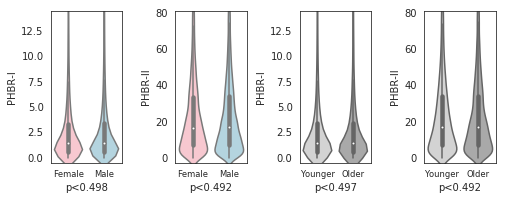


Disease: BLCA


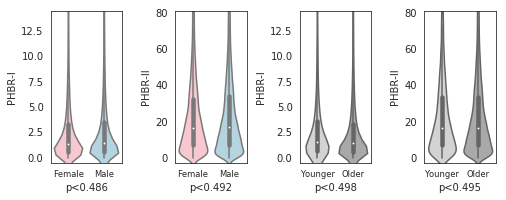


Disease: BRCA


/cellar/users/andreabc/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:4911: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


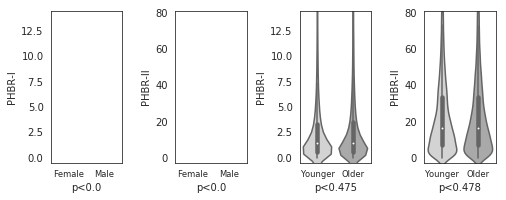


Disease: PRAD


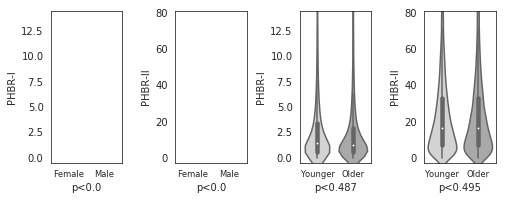


Disease: SKCM


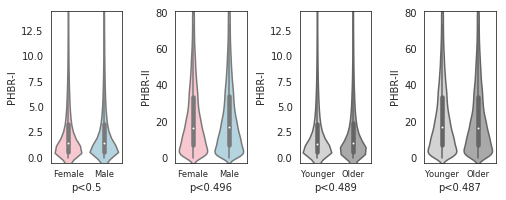


Disease: KIRC


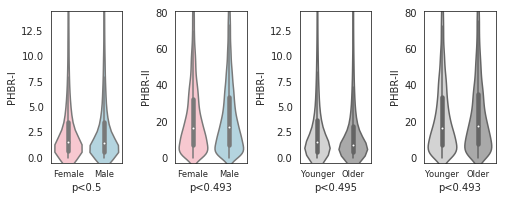


Disease: SARC


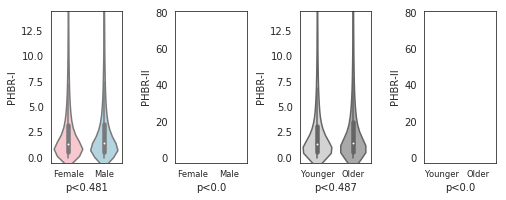


Disease: LUAD


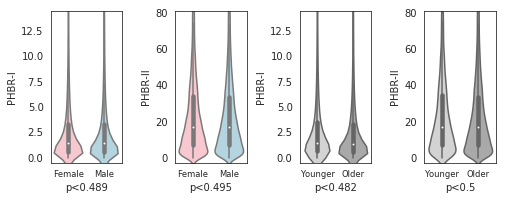


Disease: KICH


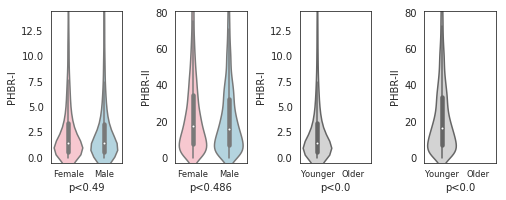


Disease: UCS


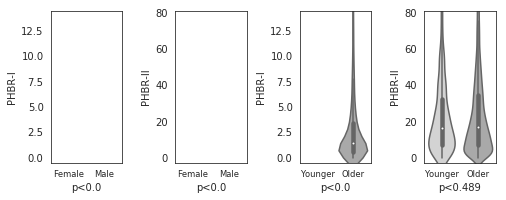


Disease: THCA


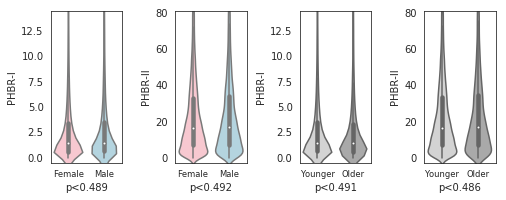


Disease: ESCA


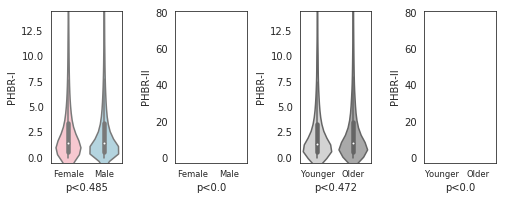


Disease: TGCT


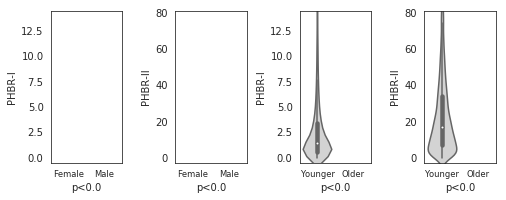


Disease: HNSC


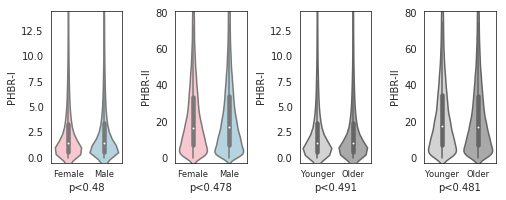


Disease: OV


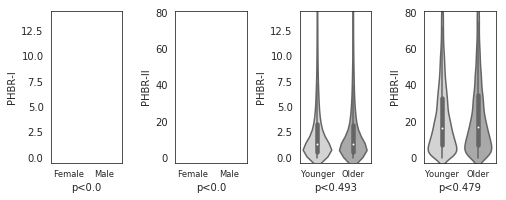


Disease: STAD


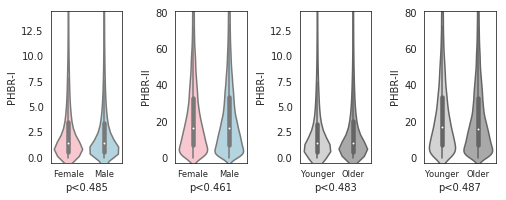


Disease: READ


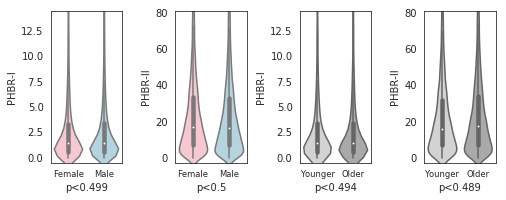


Disease: KIRP


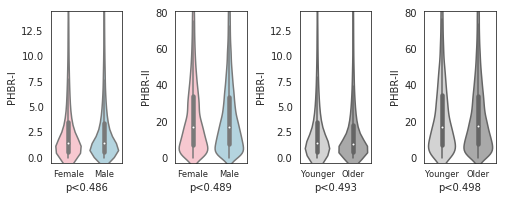


Disease: DLBC


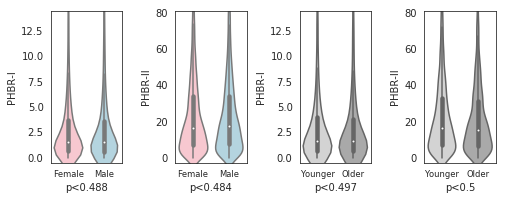


Disease: ACC


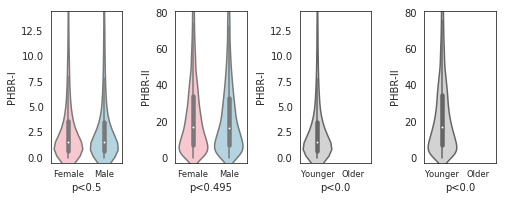


Disease: PAAD


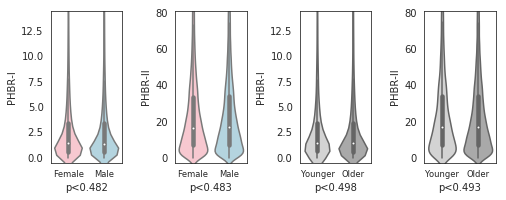


Disease: LAML


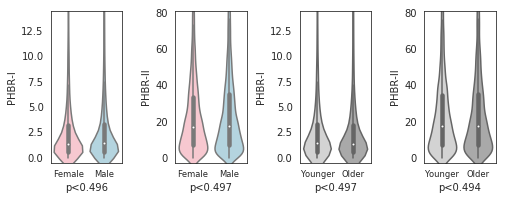


Disease: LGG


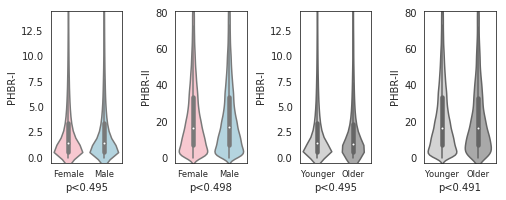


Disease: LIHC


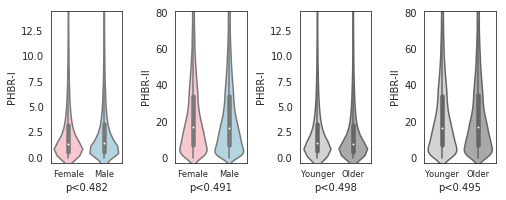


Disease: CHOL


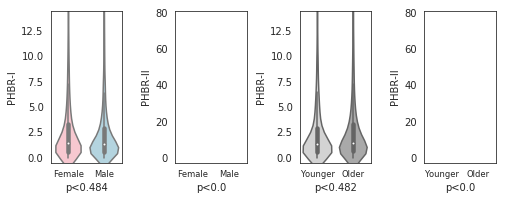


Disease: THYM


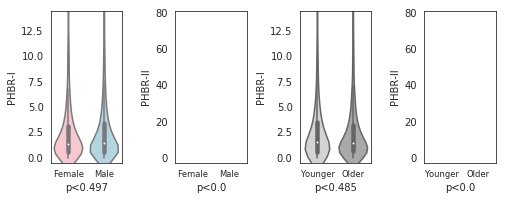


Disease: UCEC


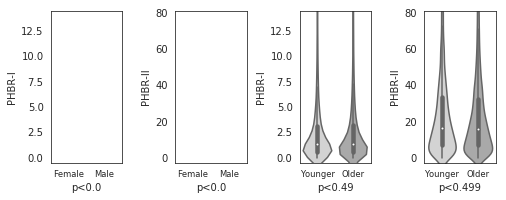


Disease: LUSC


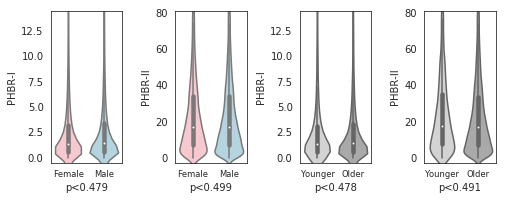


Disease: COAD


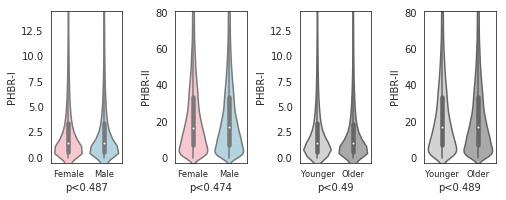


Disease: MESO


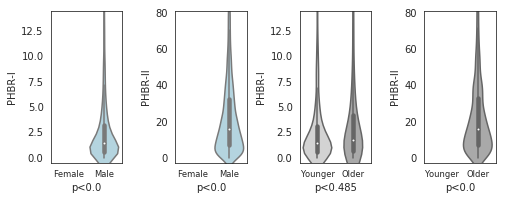


Disease: CESC


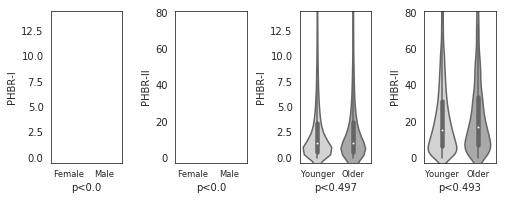


Disease: UVM


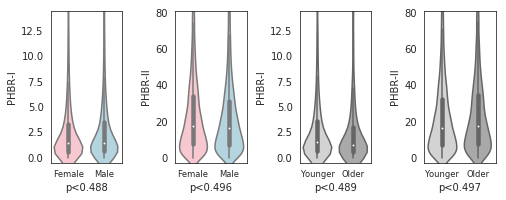


Disease: PCPG


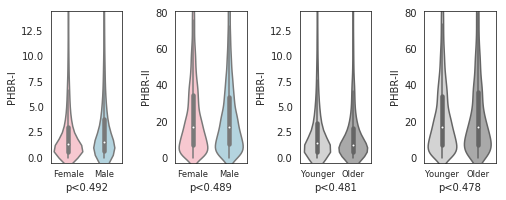

In [17]:
for disease in set(confident_patients_I_kept_sex_specific['disease'].values):

    plt.figure(figsize=(7,5))
    print('\nDisease: {}'.format(disease))

    # A - All PHBR-I scores - sex
    plt.subplot(2,4,1)
    data = affinity_I_sex_df.join(confident_patients_I_rm_sex_specific[['sex', 'disease']]).reset_index()
    data = data[data['disease']==disease]
    data = pd.melt(data, id_vars=['sex', 'index', 'disease']).drop_duplicates()
    p = mannwhitneyu(data[data['sex']=='female'].index.values, data[data['sex']=='male'].index.values).pvalue
    sns.violinplot(x='sex', y='value', data=data, order=['female', 'male'], palette=['pink', 'lightblue'])
    plt.xlabel('p<{:.3}'.format(p)), plt.ylabel('PHBR-I')
    plt.xticks([0,1], ['Female', 'Male'], fontsize='small')
    plt.ylim(ymin=-0.5, ymax=14.5)


    # B - All PHBR-II scores - sex
    plt.subplot(2,4,2)
    data = affinity_II_sex_df.join(confident_patients_II_rm_sex_specific[['sex', 'disease']]).reset_index()
    data = data[data['disease']==disease]
    data = pd.melt(data, id_vars=['sex', 'index', 'disease']).drop_duplicates()
    p = mannwhitneyu(data[data['sex']=='female'].index.values, data[data['sex']=='male'].index.values).pvalue
    sns.violinplot(x='sex', y='value', data=data, order=['female', 'male'], palette=['pink', 'lightblue'])
    plt.xlabel('p<{:.3}'.format(p)), plt.ylabel('PHBR-II')
    plt.xticks([0,1], ['Female', 'Male'], fontsize='small')
    plt.ylim(ymin=-2.7,ymax=81)


    # C - All PHBR-I scores - age
    plt.subplot(2,4,3)
    data = affinity_I_age_df.join(confident_patients_I_kept_sex_specific[['age_categorical_3070', 'disease']]).reset_index()
    data = data[data['disease']==disease]
    data = pd.melt(data, id_vars=['age_categorical_3070', 'index', 'disease']).drop_duplicates()
    p = mannwhitneyu(data[data['age_categorical_3070']=='younger'].index.values, data[data['age_categorical_3070']=='older'].index.values).pvalue
    sns.violinplot(x='age_categorical_3070', y='value', data=data, order=['younger', 'older'], palette=['lightgrey', 'darkgrey'])
    plt.xlabel('p<{:.3}'.format(p)), plt.ylabel('PHBR-I')
    plt.xticks([0,1], ['Younger', 'Older'], fontsize='small')
    plt.ylim(ymin=-0.5, ymax=14.5)


    # D - All PHBR-II scores - age
    plt.subplot(2,4,4)
    data = affinity_II_age_df.join(confident_patients_II_kept_sex_specific[['age_categorical_3070', 'disease']]).reset_index()
    data = data[data['disease']==disease]
    data = pd.melt(data, id_vars=['age_categorical_3070', 'index', 'disease']).drop_duplicates()
    p = mannwhitneyu(data[data['age_categorical_3070']=='younger'].index.values, data[data['age_categorical_3070']=='older'].index.values).pvalue
    sns.violinplot(x='age_categorical_3070', y='value', data=data, order=['younger', 'older'], palette=['lightgrey', 'darkgrey'])
    plt.xlabel('p<{:.3}'.format(p)), plt.ylabel('PHBR-II')
    plt.xticks([0,1], ['Younger', 'Older'], fontsize='small')
    plt.ylim(ymin=-2.7,ymax=81)

    plt.tight_layout(pad=0.6, h_pad=1)

# savepath = '/cellar/users/andreabc/Data/hla_sex/figures/supplementary/S2.sex_age_PHBR.{}.violin.pdf'.format(MSS)
# print('Saving to {}'.format(savepath))
# plt.savefig(savepath)
    plt.show()

### ECDF of fraction of driver mutations presented 

In [11]:
from scipy.stats import ks_2samp

In [32]:
# mhcI 
thresholds_I = range(0,21,1)
f_medians_list_I, m_medians_list_I = [],[]
y_medians_list_I, o_medians_list_I = [],[]

for threshold in thresholds_I:
    # sex
    data = pd.DataFrame((affinity_I_sex_df < threshold).sum(axis=1) / len(affinity_I_sex_df.columns), columns=['fraction'])
    data = data.join(confident_patients_I_rm_sex_specific[['sex']])
    
    f_medians_list_I.append(data[data['sex']=='female'].fraction.median())
    m_medians_list_I.append(data[data['sex']=='male'].fraction.median())
    
    # age
    data = pd.DataFrame((affinity_I_age_df < threshold).sum(axis=1) / len(affinity_I_age_df.columns), columns=['fraction'])
    data = data.join(confident_patients_I_kept_sex_specific[['age_categorical_3070']])
    
    y_medians_list_I.append(data[data['age_categorical_3070']=='younger'].fraction.median())
    o_medians_list_I.append(data[data['age_categorical_3070']=='older'].fraction.median())

In [33]:
# mhcII
thresholds_II = range(0,81,1)
f_medians_list_II, m_medians_list_II = [],[]
y_medians_list_II, o_medians_list_II = [],[]

for threshold in thresholds_II:
    # sex
    data = pd.DataFrame((affinity_II_sex_df < threshold).sum(axis=1) / len(affinity_II_sex_df.columns), columns=['fraction'])
    data = data.join(confident_patients_II_rm_sex_specific[['sex']])
    
    f_medians_list_II.append(data[data['sex']=='female'].fraction.median())
    m_medians_list_II.append(data[data['sex']=='male'].fraction.median())
    
    # age
    data = pd.DataFrame((affinity_II_age_df < threshold).sum(axis=1) / len(affinity_II_age_df.columns), columns=['fraction'])
    data = data.join(confident_patients_II_kept_sex_specific[['age_categorical_3070']])
    
    y_medians_list_II.append(data[data['age_categorical_3070']=='younger'].fraction.median())
    o_medians_list_II.append(data[data['age_categorical_3070']=='older'].fraction.median())

Saving to /cellar/users/andreabc/Data/hla_sex/figures/supplementary/S3_fraction_ECDF.pdf


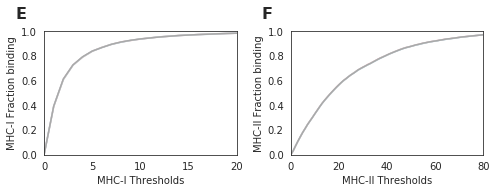

In [34]:
plt.figure(figsize=(7,2.5))

# A - All PHBR-I scores - sex
fig = plt.subplot(1,2,1)
# p = ks_2samp(f_medians_list_I, m_medians_list_I).pvalue

plt.plot(thresholds_I, f_medians_list_I, color='lightpink')
plt.plot(thresholds_I, m_medians_list_I, color='lightblue')
plt.plot(thresholds_I, y_medians_list_I, color='lightgrey')
plt.plot(thresholds_I, o_medians_list_I, color='darkgrey')
plt.text(-0.15, 1.1, 'E', transform=fig.transAxes, fontsize=16,  weight='bold')
plt.xlabel('MHC-I Thresholds'), plt.ylabel('MHC-I Fraction binding')
plt.ylim(0,1), plt.xlim(0,20)


# plt.title('Median fraction of binding driver mutations')
# plt.xlabel('KS 2-sample test: p<{:.3}'.format(p)), plt.ylabel('Fraction of binding driver muts')


# B - All PHBR-II scores - sex
fig = plt.subplot(1,2,2)
p = ks_2samp(f_medians_list_II, m_medians_list_II).pvalue

plt.plot(thresholds_II, f_medians_list_II, color='lightpink')
plt.plot(thresholds_II, m_medians_list_II, color='lightblue')
plt.plot(thresholds_II, y_medians_list_II, color='lightgrey')
plt.plot(thresholds_II, o_medians_list_II, color='darkgrey')
plt.text(-0.15, 1.1, 'F', transform=fig.transAxes, fontsize=16,  weight='bold')
plt.xlabel('MHC-II Thresholds'), plt.ylabel('MHC-II Fraction binding')
plt.ylim(0,1), plt.xlim(0,80)

plt.tight_layout()
savepath = '/cellar/users/andreabc/Data/hla_sex/figures/supplementary/S3_fraction_ECDF.pdf'
print('Saving to {}'.format(savepath)), plt.savefig(savepath, bbox_inches="tight")
plt.show()

# Validation

In [2]:
mhcI_df = pd.read_csv('/cellar/users/andreabc/Data/hla_sex/validation/clean_data/boxplot_data.MHC-I.tsv', sep='\t', index_col=0)
mhcII_df = pd.read_csv('/cellar/users/andreabc/Data/hla_sex/validation/clean_data/boxplot_data.MHC-II.tsv', sep='\t', index_col=0)

mhcI_df.head(2)

,PHBR_score,age,age_categorical_3070,mutation_id,project_code,sex,tumor_type
DO27765,0.985454,4.0,younger,M_TP53_S215R,NaN,male,MALY
DO27775,5.304091,4.0,younger,M_TP53_R273H,NaN,male,MALY


In [3]:
# subset for analysis
affinity_I_df = pd.read_csv('/cellar/users/andreabc/Data/hla_sex/validation/clean_data/driver_mut.class_i.ICGC.affinities', sep='\t', index_col=0)
affinity_I_df = affinity_I_df.append(pd.read_csv('/cellar/users/andreabc/Data/hla_sex/validation/clean_data/driver_mut.class_i.ICGC.THCA-SA.affinities', sep='\t', index_col=0))
affinity_I_df = affinity_I_df.append(pd.read_csv('/cellar/users/andreabc/Data/hla_sex/validation/clean_data/driver_mut.class_i.phs000452.v2.p1.c1_MelanomaGenomeSeq.affinities', sep='\t', index_col=0))
affinity_I_df = affinity_I_df.append(pd.read_csv('/cellar/users/andreabc/Data/hla_sex/validation/clean_data/driver_mut.class_i.phs001451.v1.p1.c1_PhaseIMelanomaVac.affinities', sep='\t', index_col=0))
affinity_I_df = affinity_I_df.append(pd.read_csv('/cellar/users/andreabc/Data/hla_sex/validation/clean_data/driver_mut.class_i.phs001519.v1.p1.c1_GBMPhaseIVaccine.affinities', sep='\t', index_col=0))
affinity_I_df = affinity_I_df.append(pd.read_csv('/cellar/users/andreabc/Data/hla_sex/validation/clean_data/driver_mut.class_i.phs001565.v1.p1.c1_GenCorrRespResICB_CancerMDS.affinities', sep='\t', index_col=0))
affinity_I_df = affinity_I_df[affinity_I_df.index.isin(mhcI_df.index)]

affinity_II_df = pd.read_csv('/cellar/users/andreabc/Data/hla_sex/validation/clean_data/driver_mut.class_ii.ICGC.affinities', sep='\t', index_col=0)
affinity_II_df = affinity_II_df.append(pd.read_csv('/cellar/users/andreabc/Data/hla_sex/validation/clean_data/driver_mut.class_ii.ICGC.THCA-SA.affinities', sep='\t', index_col=0))
affinity_II_df = affinity_II_df.append(pd.read_csv('/cellar/users/andreabc/Data/hla_sex/validation/clean_data/driver_mut.class_ii.phs000452.v2.p1.c1_MelanomaGenomeSeq.affinities', sep='\t', index_col=0))
affinity_II_df = affinity_II_df.append(pd.read_csv('/cellar/users/andreabc/Data/hla_sex/validation/clean_data/driver_mut.class_ii.phs001451.v1.p1.c1_PhaseIMelanomaVac.affinities', sep='\t', index_col=0))
affinity_II_df = affinity_II_df.append(pd.read_csv('/cellar/users/andreabc/Data/hla_sex/validation/clean_data/driver_mut.class_ii.phs001519.v1.p1.c1_GBMPhaseIVaccine.affinities', sep='\t', index_col=0))
affinity_II_df = affinity_II_df.append(pd.read_csv('/cellar/users/andreabc/Data/hla_sex/validation/clean_data/driver_mut.class_ii.phs001565.v1.p1.c1_GenCorrRespResICB_CancerMDS.affinities', sep='\t', index_col=0))
affinity_II_df = affinity_II_df[affinity_II_df.index.isin(mhcII_df.index)]

/cellar/users/andreabc/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Saving to /cellar/users/andreabc/Data/hla_sex/figures/supplementary/valid_S2.sex_age_PHBR.MSS_only.violin.pdf


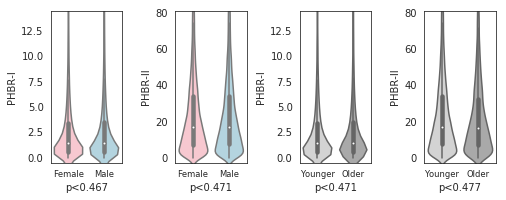

In [49]:
plt.figure(figsize=(7,5))

# A - All PHBR-I scores - sex
plt.subplot(2,4,1)
data = affinity_I_df.join(mhcI_df[['sex']]).reset_index()
data = pd.melt(data, id_vars=['sex', 'index']).drop_duplicates()
p = mannwhitneyu(data[data['sex']=='female'].index.values, data[data['sex']=='male'].index.values).pvalue
sns.violinplot(x='sex', y='value', data=data, order=['female', 'male'], palette=['pink', 'lightblue'])
plt.xlabel('p<{:.3}'.format(p)), plt.ylabel('PHBR-I')
plt.xticks([0,1], ['Female', 'Male'], fontsize='small')
plt.ylim(ymin=-0.5, ymax=14.5)


# B - All PHBR-II scores - sex
plt.subplot(2,4,2)
data = affinity_II_df.join(mhcII_df[['sex']]).reset_index()
data = pd.melt(data, id_vars=['sex', 'index']).drop_duplicates()
p = mannwhitneyu(data[data['sex']=='female'].index.values, data[data['sex']=='male'].index.values).pvalue
sns.violinplot(x='sex', y='value', data=data, order=['female', 'male'], palette=['pink', 'lightblue'])
plt.xlabel('p<{:.3}'.format(p)), plt.ylabel('PHBR-II')
plt.xticks([0,1], ['Female', 'Male'], fontsize='small')
plt.ylim(ymin=-2.7,ymax=81)


# C - All PHBR-I scores - age
plt.subplot(2,4,3)
data = affinity_I_df.join(mhcI_df[['age_categorical_3070']]).reset_index()
data = pd.melt(data, id_vars=['age_categorical_3070', 'index']).drop_duplicates()
p = mannwhitneyu(data[data['age_categorical_3070']=='younger'].index.values, data[data['age_categorical_3070']=='older'].index.values).pvalue
sns.violinplot(x='age_categorical_3070', y='value', data=data, order=['younger', 'older'], palette=['lightgrey', 'darkgrey'])
plt.xlabel('p<{:.3}'.format(p)), plt.ylabel('PHBR-I')
plt.xticks([0,1], ['Younger', 'Older'], fontsize='small')
plt.ylim(ymin=-0.5, ymax=14.5)


# D - All PHBR-II scores - age
plt.subplot(2,4,4)
data = affinity_II_df.join(mhcII_df[['age_categorical_3070']]).reset_index()
data = pd.melt(data, id_vars=['age_categorical_3070', 'index']).drop_duplicates()
p = mannwhitneyu(data[data['age_categorical_3070']=='younger'].index.values, data[data['age_categorical_3070']=='older'].index.values).pvalue
sns.violinplot(x='age_categorical_3070', y='value', data=data, order=['younger', 'older'], palette=['lightgrey', 'darkgrey'])
plt.xlabel('p<{:.3}'.format(p)), plt.ylabel('PHBR-II')
plt.xticks([0,1], ['Younger', 'Older'], fontsize='small')
plt.ylim(ymin=-2.7,ymax=81)

plt.tight_layout(pad=0.6, h_pad=1)

savepath = '/cellar/users/andreabc/Data/hla_sex/figures/supplementary/valid_S2.sex_age_PHBR.{}.violin.pdf'.format(MSS)
print('Saving to {}'.format(savepath))
plt.savefig(savepath)
plt.show()

##### For disease types


Disease: nan


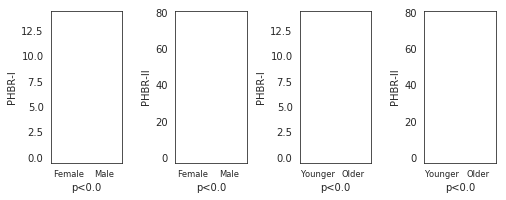


Disease: GBM


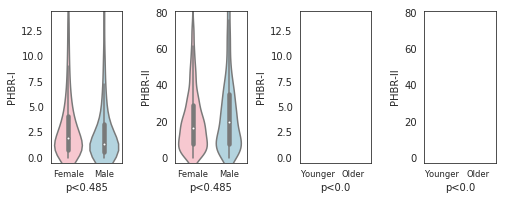


Disease: BTCA


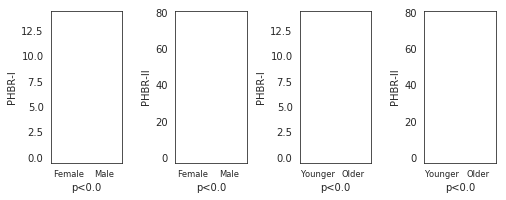


Disease: ORCA


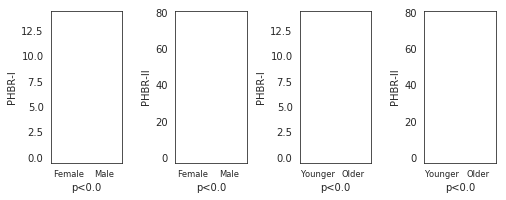


Disease: LINC


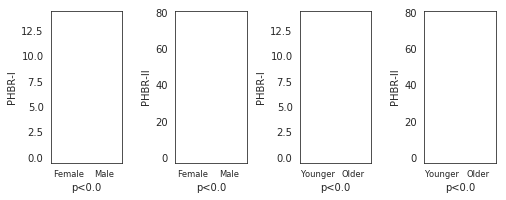


Disease: Bladder


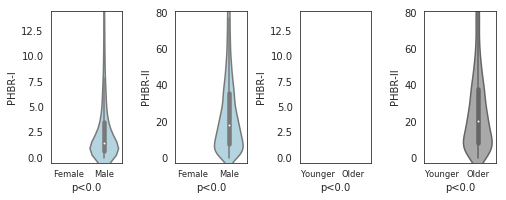


Disease: BOCA


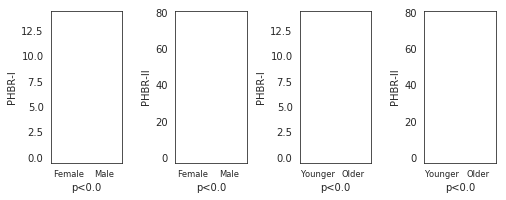


Disease: ESAD


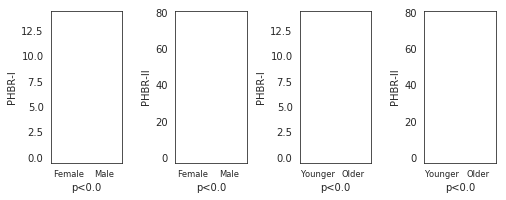


Disease: CLLE


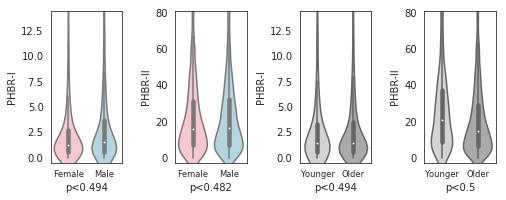


Disease: CMDI


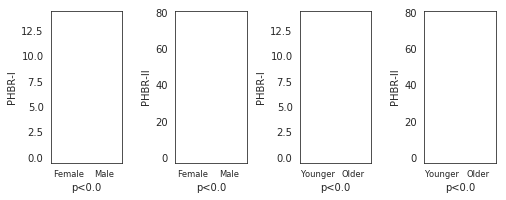


Disease: GACA


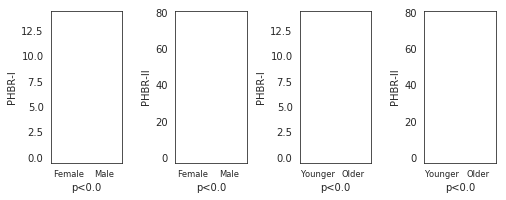


Disease: HNSCC


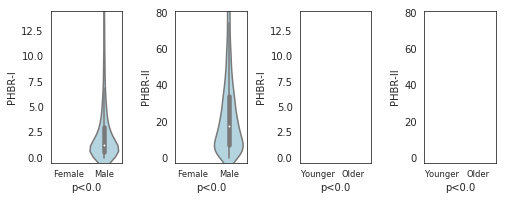


Disease: MELA


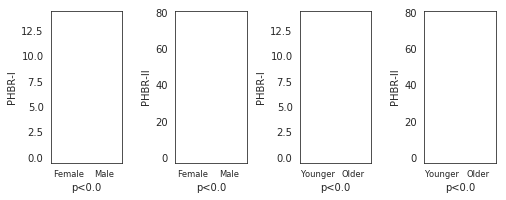


Disease: THCA


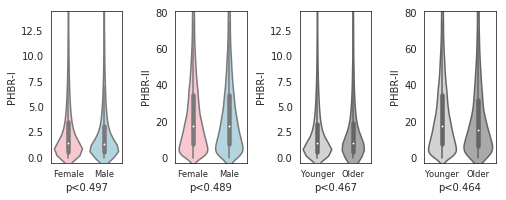


Disease: RECA


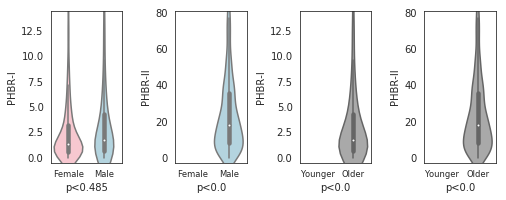


Disease: LIRI


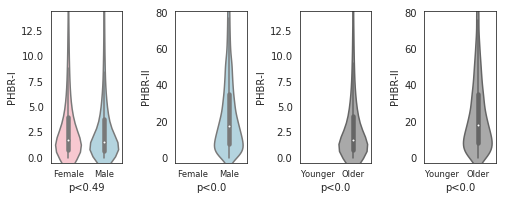


Disease: PACA


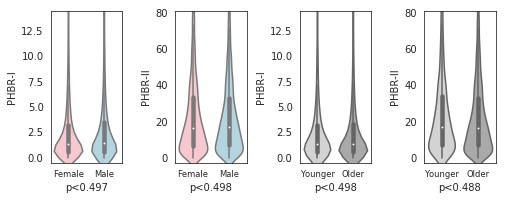


Disease: LAML


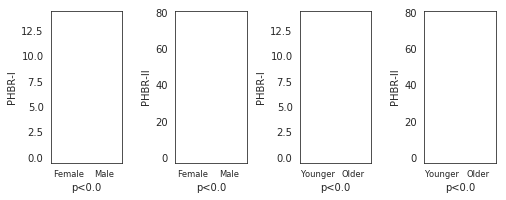


Disease: PAEN


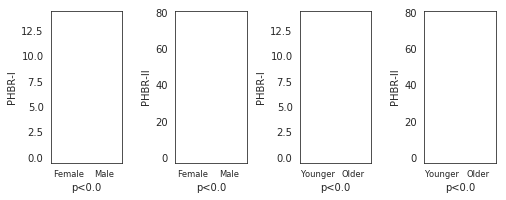


Disease: Melanoma


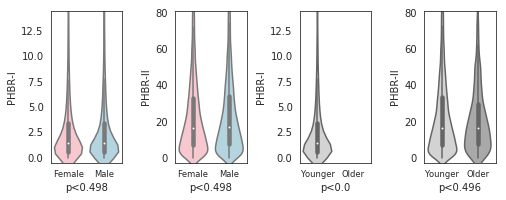


Disease: Lung


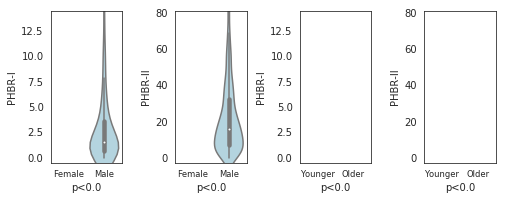


Disease: MALY


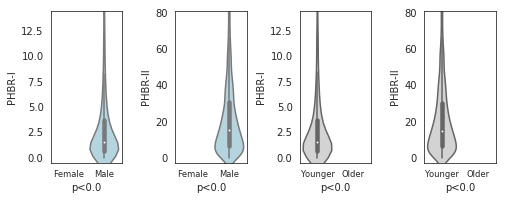

In [53]:
for disease in set(mhcI_df['tumor_type'].values):
    print('\nDisease: {}'.format(disease))
    
    plt.figure(figsize=(7,5))

    # A - All PHBR-I scores - sex
    plt.subplot(2,4,1)
    data = affinity_I_df.join(mhcI_df[['sex', 'tumor_type']]).reset_index()
    data = data[data['tumor_type']==disease]
    data = pd.melt(data, id_vars=['sex', 'index', 'tumor_type']).drop_duplicates()
    p = mannwhitneyu(data[data['sex']=='female'].index.values, data[data['sex']=='male'].index.values).pvalue
    sns.violinplot(x='sex', y='value', data=data, order=['female', 'male'], palette=['pink', 'lightblue'])
    plt.xlabel('p<{:.3}'.format(p)), plt.ylabel('PHBR-I')
    plt.xticks([0,1], ['Female', 'Male'], fontsize='small')
    plt.ylim(ymin=-0.5, ymax=14.5)


    # B - All PHBR-II scores - sex
    plt.subplot(2,4,2)
    data = affinity_II_df.join(mhcII_df[['sex', 'tumor_type']]).reset_index()
    data = data[data['tumor_type']==disease]
    data = pd.melt(data, id_vars=['sex', 'index', 'tumor_type']).drop_duplicates()
    p = mannwhitneyu(data[data['sex']=='female'].index.values, data[data['sex']=='male'].index.values).pvalue
    sns.violinplot(x='sex', y='value', data=data, order=['female', 'male'], palette=['pink', 'lightblue'])
    plt.xlabel('p<{:.3}'.format(p)), plt.ylabel('PHBR-II')
    plt.xticks([0,1], ['Female', 'Male'], fontsize='small')
    plt.ylim(ymin=-2.7,ymax=81)


    # C - All PHBR-I scores - age
    plt.subplot(2,4,3)
    data = affinity_I_df.join(mhcI_df[['age_categorical_3070', 'tumor_type']]).reset_index()
    data = data[data['tumor_type']==disease]
    data = pd.melt(data, id_vars=['age_categorical_3070', 'index', 'tumor_type']).drop_duplicates()
    p = mannwhitneyu(data[data['age_categorical_3070']=='younger'].index.values, data[data['age_categorical_3070']=='older'].index.values).pvalue
    sns.violinplot(x='age_categorical_3070', y='value', data=data, order=['younger', 'older'], palette=['lightgrey', 'darkgrey'])
    plt.xlabel('p<{:.3}'.format(p)), plt.ylabel('PHBR-I')
    plt.xticks([0,1], ['Younger', 'Older'], fontsize='small')
    plt.ylim(ymin=-0.5, ymax=14.5)


    # D - All PHBR-II scores - age
    plt.subplot(2,4,4)
    data = affinity_II_df.join(mhcII_df[['age_categorical_3070', 'tumor_type']]).reset_index()
    data = data[data['tumor_type']==disease]
    data = pd.melt(data, id_vars=['age_categorical_3070', 'index', 'tumor_type']).drop_duplicates()
    p = mannwhitneyu(data[data['age_categorical_3070']=='younger'].index.values, data[data['age_categorical_3070']=='older'].index.values).pvalue
    sns.violinplot(x='age_categorical_3070', y='value', data=data, order=['younger', 'older'], palette=['lightgrey', 'darkgrey'])
    plt.xlabel('p<{:.3}'.format(p)), plt.ylabel('PHBR-II')
    plt.xticks([0,1], ['Younger', 'Older'], fontsize='small')
    plt.ylim(ymin=-2.7,ymax=81)

    plt.tight_layout(pad=0.6, h_pad=1)

#     savepath = '/cellar/users/andreabc/Data/hla_sex/figures/supplementary/valid_S2.sex_age_PHBR.{}.violin.pdf'.format(MSS)
#     print('Saving to {}'.format(savepath))
#     plt.savefig(savepath)
    plt.show()

### Post analysis of heterozygosity 
- remove all patients with MHC-I or MHC-II homozygosity

In [2]:
from collections import defaultdict
from scipy.stats import fisher_exact

In [3]:
# discovery
mhcI_types_df = pd.read_csv('/cellar/users/andreabc/Data/TCGA/hla_types/all_mhc_i_types.txt', sep='\t', index_col=0)
mhcII_types_df = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/hla_types/hla_types.tcga.csv', index_col=0)



/cellar/users/andreabc/miniconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


In [4]:
val_II_df.head(2)

,DPA1_allele1,DPA1_allele2,DPB1_allele1,DPB1_allele2,DQA1_allele1,DQA1_allele2,DQB1_allele1,DQB1_allele2,DRB1_allele1,DRB1_allele2
DO223388,DPA10103,DPA10103,DPB10201,DPB10401,DQA10501,DQA10102,DQB10602,DQB10602,DRB11501,DRB10315
DO228267,DPA10103,DPA10103,DPB10401,DPB10401,DQA10505,DQA10102,DQB10301,DQB10602,DRB11101,DRB11501


### discovery

In [32]:
# MHC-I sex patients
mhcI_sex_patients = affinity_I_sex_df.index.values
mhcI_sex_types_df = mhcI_df[mhcI_df.index.isin(mhcI_sex_patients)]

# MHC-I age patients
mhcI_age_patients = affinity_I_age_df.index.values
mhcI_age_types_df = mhcII_df[mhcII_df.index.isin(mhcI_age_patients)]

In [13]:
# MHC-II sex patients
mhcII_sex_patients = affinity_II_sex_df.index.values
mhcII_sex_types_df = mhcII_types_df[mhcII_types_df.index.isin(mhcII_sex_patients)]

# MHC-II age patients
mhcII_age_patients = affinity_II_age_df.index.values
mhcII_age_types_df = mhcII_types_df[mhcII_types_df.index.isin(mhcII_age_patients)]

In [14]:
alleleI_set = {
    'HLA-A': ['HLA-A1', 'HLA-A2'],
    'HLA-B': ['HLA-B1', 'HLA-B2'],
    'HLA-C': ['HLA-C1', 'HLA-C2']
}

alleleII_set = {
    'DPA1': ['DPA1_allele1', 'DPA1_allele2'],
    'DPB1': ['DPB1_allele1', 'DPB1_allele2'],
    'DQA1': ['DQA1_allele1', 'DQA1_allele2'],
    'DQB1': ['DQB1_allele1', 'DQB1_allele2'],
    'DRB1': ['DRB1_allele1', 'DRB1_allele2']
}

In [12]:
homozygous_dict_I = defaultdict(list)
homozygous_dict_II = defaultdict(list)

for patient, row in mhcI_types_df.iterrows():
    for allele in alleleI_set.keys():
        if row[alleleI_set[allele]][0] == row[alleleI_set[allele]][1]:
            homozygous_dict_I[allele].append(patient)

for patient, row in mhcII_types_df.iterrows():
    for allele in alleleII_set.keys():
        if row[alleleII_set[allele]][0] == row[alleleII_set[allele]][1]:
            homozygous_dict_II[allele].append(patient)

In [13]:
homozygous_patients_I = []
for allele in homozygous_dict_I.keys():
    print('{}: {}'.format(allele, len(homozygous_dict_I[allele])))
    homozygous_patients_I.extend(homozygous_dict_I[allele])
    
homozygous_patients_II = []
for allele in homozygous_dict_II.keys():
    print('{}: {}'.format(allele, len(homozygous_dict_II[allele])))
    homozygous_patients_II.extend(homozygous_dict_II[allele])

HLA-A: 1433
HLA-C: 1076
HLA-B: 802
DPA1: 5497
DPB1: 1847
DQB1: 1077
DQA1: 880
DRB1: 729


In [14]:
clinical = pd.read_csv('/cellar/users/andreabc/Data/TCGA/clinical/all_clinical_tcga_with_disease.txt', sep='\t')
# clinical = clinical[clinical['bcr_patient_barcode'].isin(mhcII_sex_patients)]

In [15]:
homozygous_patients_I = list(set(homozygous_patients_I))
homozygous_patients_II = list(set(homozygous_patients_II))

print('I: {} II: {} homozygous patients'.format(len(homozygous_patients_I), len(homozygous_patients_II)))

I: 2430 II: 5985 homozygous patients


In [16]:
hetero_patients_I = [x for x in clinical['bcr_patient_barcode'].values if x not in homozygous_patients_I]
hetero_patients_II = [x for x in clinical['bcr_patient_barcode'].values if x not in homozygous_patients_II]

print('I: {} II: {} homozygous patients'.format(len(hetero_patients_I), len(hetero_patients_II)))

I: 2088 II: 754 homozygous patients


In [50]:
np.savetxt('/cellar/users/andreabc/Data/hla_sex/clean_data/mhcI.homozygous_allele_patients.txt', homozygous_patients_I, delimiter='\n', fmt='%s')
np.savetxt('/cellar/users/andreabc/Data/hla_sex/clean_data/mhcII.homozygous_allele_patients.txt', homozygous_patients_II, delimiter='\n', fmt='%s')

In [17]:
# mhc I
male_homozy_I = clinical[(clinical['bcr_patient_barcode'].isin(homozygous_patients_I)) & (clinical['gender']=='MALE')]
female_homozy_I = clinical[(clinical['bcr_patient_barcode'].isin(homozygous_patients_I)) & (clinical['gender']=='FEMALE')]

male_hetero_I = clinical[(clinical['bcr_patient_barcode'].isin(hetero_patients_I)) & (clinical['gender']=='MALE')]
female_hetero_I = clinical[(clinical['bcr_patient_barcode'].isin(hetero_patients_I)) & (clinical['gender']=='FEMALE')]

# mhc II
male_homozy_II = clinical[(clinical['bcr_patient_barcode'].isin(homozygous_patients_II)) & (clinical['gender']=='MALE')]
female_homozy_II = clinical[(clinical['bcr_patient_barcode'].isin(homozygous_patients_II)) & (clinical['gender']=='FEMALE')]

male_hetero_II = clinical[(clinical['bcr_patient_barcode'].isin(hetero_patients_II)) & (clinical['gender']=='MALE')]
female_hetero_II = clinical[(clinical['bcr_patient_barcode'].isin(hetero_patients_II)) & (clinical['gender']=='FEMALE')]

In [21]:
print('Male I: {:.3}'.format(len(male_homozy_I)/(len(male_homozy_I)+len(male_hetero_I))))
print('Female I: {:.3}'.format(len(female_homozy_I)/(len(female_homozy_I)+len(female_hetero_I))))

print('Male II: {:.3}'.format(len(male_homozy_II)/(len(male_homozy_II)+len(male_hetero_II))))
print('Female II: {:.3}'.format(len(female_homozy_II)/(len(female_homozy_II)+len(female_hetero_II))))

Male I: 0.227
Female I: 0.213
Male II: 0.719
Female II: 0.719


#### Validation

In [10]:
from collections import defaultdict

In [6]:
mhcI_df = pd.read_csv('/cellar/users/andreabc/Data/hla_sex/validation/clean_data/boxplot_data.MHC-I.tsv', sep='\t', index_col=0)
mhcII_df = pd.read_csv('/cellar/users/andreabc/Data/hla_sex/validation/clean_data/boxplot_data.MHC-II.tsv', sep='\t', index_col=0)

mhcI_df.head(2)

,PHBR_score,age,age_categorical_3070,mutation_id,project_code,sex,tumor_type
DO27765,0.985454,4.0,younger,M_TP53_S215R,NaN,male,MALY
DO27775,5.304091,4.0,younger,M_TP53_R273H,NaN,male,MALY


In [5]:
# validation
# subset for analysis
val_I_df = pd.read_csv('/nrnb/users/andreabc/Data/ICGC/clean_output/class_i.hla_types.WGS-nonPCAWG.csv',index_col=0)
val_I_df = val_I_df.append(pd.read_csv('/nrnb/users/andreabc/Data/ICGC/clean_output/class_i.hla_types.paired_bams.normal.csv', sep='\t', index_col=0))
val_I_df = val_I_df.append(pd.read_csv('/nrnb/users/andreabc/Data/ICGC/clean_output/class_i.hla_types.EGA_WGS.csv', sep='\t', index_col=0))
val_I_df = val_I_df.append(pd.read_csv('/nrnb/users/andreabc/Data/SRA/2019_dbGap_phs000452.v2.p1.c1_MelanomaGenomeSeq/class_i.hla_types.HLA-HD.csv', sep='\t', index_col=0))
val_I_df = val_I_df.append(pd.read_csv('/nrnb/users/andreabc/Data/SRA/2019_dbGap_phs001451.v1.p1.c1_PhaseIMelanomaVac/class_i.hla_types.HLA-HD.csv', sep='\t', index_col=0))
val_I_df = val_I_df.append(pd.read_csv('/nrnb/users/andreabc/Data/SRA/2019_dbGap_phs001519.v1.p1.c1_GBMPhaseIVaccine/class_i.hla_types.HLA-HD.csv', sep='\t', index_col=0))
val_I_df = val_I_df.append(pd.read_csv('/nrnb/users/andreabc/Data/SRA/2019_dbGap_phs001565.v1.p1.c1_GenCorrRespResICB_CancerMDS/class_i.hla_types.HLA-HD.csv', sep='\t', index_col=0))


# val_I_df = val_I_df[val_I_df.index.isin(mhcI_df.index)]

val_II_df = pd.read_csv('/nrnb/users/andreabc/Data/ICGC/clean_output/class_ii.hla_types.WGS-nonPCAWG.csv',index_col=0)
val_II_df = val_II_df.append(pd.read_csv('/nrnb/users/andreabc/Data/ICGC/clean_output/class_ii.hla_types.paired_bams.normal.csv', sep='\t', index_col=0))
val_II_df = val_II_df.append(pd.read_csv('/nrnb/users/andreabc/Data/ICGC/clean_output/class_ii.hla_types.EGA_WGS.csv', sep='\t', index_col=0))
val_II_df = val_II_df.append(pd.read_csv('/nrnb/users/andreabc/Data/SRA/2019_dbGap_phs000452.v2.p1.c1_MelanomaGenomeSeq/class_ii.hla_types.HLA-HD.csv', sep='\t', index_col=0))
val_II_df = val_II_df.append(pd.read_csv('/nrnb/users/andreabc/Data/SRA/2019_dbGap_phs001451.v1.p1.c1_PhaseIMelanomaVac/class_ii.hla_types.HLA-HD.csv', sep='\t', index_col=0))
val_II_df = val_II_df.append(pd.read_csv('/nrnb/users/andreabc/Data/SRA/2019_dbGap_phs001519.v1.p1.c1_GBMPhaseIVaccine/class_ii.hla_types.HLA-HD.csv', sep='\t', index_col=0))
val_II_df = val_II_df.append(pd.read_csv('/nrnb/users/andreabc/Data/SRA/2019_dbGap_phs001565.v1.p1.c1_GenCorrRespResICB_CancerMDS/class_ii.hla_types.HLA-HD.csv', sep='\t', index_col=0))

/cellar/users/andreabc/miniconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


In [7]:
# MHC-I patients
mhcI_patients = mhcI_df.index.values
mhcI_types_df = val_I_df[val_I_df.index.isin(mhcI_patients)]

# MHC-II age patients
mhcII_patients = mhcII_df.index.values
mhcII_types_df = val_II_df[val_II_df.index.isin(mhcII_patients)]
mhcII_types_df.head(2)

,DPA1_allele1,DPA1_allele2,DPB1_allele1,DPB1_allele2,DQA1_allele1,DQA1_allele2,DQB1_allele1,DQB1_allele2,DRB1_allele1,DRB1_allele2
DO223401,DPA10103,DPA10103,DPB10401,DPB10401,DQA10505,DQA10102,DQB10602,DQB10301,DRB11501,DRB11201
DO223413,DPA10103,DPA10103,DPB10202,DPB10401,DQA10601,DQA10505,DQB10301,DQB10319,DRB10803,DRB11102


In [8]:
alleleI_set = {
    'HLA-A': ['HLA-A1', 'HLA-A2'],
    'HLA-B': ['HLA-B1', 'HLA-B2'],
    'HLA-C': ['HLA-C1', 'HLA-C2']
}

alleleII_set = {
    'DPA1': ['DPA1_allele1', 'DPA1_allele2'],
    'DPB1': ['DPB1_allele1', 'DPB1_allele2'],
    'DQA1': ['DQA1_allele1', 'DQA1_allele2'],
    'DQB1': ['DQB1_allele1', 'DQB1_allele2'],
    'DRB1': ['DRB1_allele1', 'DRB1_allele2']
}

In [11]:
homozygous_dict_I = defaultdict(list)
homozygous_dict_II = defaultdict(list)

for patient, row in mhcI_types_df.iterrows():
    for allele in alleleI_set.keys():
        if row[alleleI_set[allele]][0] == row[alleleI_set[allele]][1]:
            homozygous_dict_I[allele].append(patient)

for patient, row in mhcII_types_df.iterrows():
    for allele in alleleII_set.keys():
        if row[alleleII_set[allele]][0] == row[alleleII_set[allele]][1]:
            homozygous_dict_II[allele].append(patient)

In [12]:
homozygous_patients_I = []
for allele in homozygous_dict_I.keys():
    print('{}: {}'.format(allele, len(homozygous_dict_I[allele])))
    homozygous_patients_I.extend(homozygous_dict_I[allele])
    
homozygous_patients_II = []
for allele in homozygous_dict_II.keys():
    print('{}: {}'.format(allele, len(homozygous_dict_II[allele])))
    homozygous_patients_II.extend(homozygous_dict_II[allele])

HLA-A: 1
DPA1: 2
DPB1: 1
DQA1: 1


In [13]:
homozygous_patients_I = list(set(homozygous_patients_I))
homozygous_patients_II = list(set(homozygous_patients_II))

print('I: {} II: {} homozygous patients'.format(len(homozygous_patients_I), len(homozygous_patients_II)))

I: 1 II: 3 homozygous patients


In [14]:
hetero_patients_I = [x for x in mhcI_patients if x not in homozygous_patients_I]
hetero_patients_II = [x for x in mhcII_patients if x not in homozygous_patients_II]

print('I: {} II: {} homozygous patients'.format(len(hetero_patients_I), len(hetero_patients_II)))

I: 720 II: 637 homozygous patients


In [ ]:
# mhc I
male_homozy_I = clinical[(clinical['bcr_patient_barcode'].isin(homozygous_patients_I)) & (clinical['gender']=='MALE')]
female_homozy_I = clinical[(clinical['bcr_patient_barcode'].isin(homozygous_patients_I)) & (clinical['gender']=='FEMALE')]

male_hetero_I = clinical[(clinical['bcr_patient_barcode'].isin(hetero_patients_I)) & (clinical['gender']=='MALE')]
female_hetero_I = clinical[(clinical['bcr_patient_barcode'].isin(hetero_patients_I)) & (clinical['gender']=='FEMALE')]

# mhc II
male_homozy_II = clinical[(clinical['bcr_patient_barcode'].isin(homozygous_patients_II)) & (clinical['gender']=='MALE')]
female_homozy_II = clinical[(clinical['bcr_patient_barcode'].isin(homozygous_patients_II)) & (clinical['gender']=='FEMALE')]

male_hetero_II = clinical[(clinical['bcr_patient_barcode'].isin(hetero_patients_II)) & (clinical['gender']=='MALE')]
female_hetero_II = clinical[(clinical['bcr_patient_barcode'].isin(hetero_patients_II)) & (clinical['gender']=='FEMALE')]

In [15]:
# plt.figure(figsize=(6,4))

# plt.subplot(1,2,1)
# plt.bar(['Female', 'Male'], [len(female_homozy_I), len(male_homozy_I)], color=['lightpink', 'lightblue'])
# plt.ylabel('Number of patients with\nhomozygous alleles'), plt.title('MHC-I')

# plt.subplot(1,2,2)
# plt.bar(['Female', 'Male'], [len(female_homozy_II), len(male_homozy_II)], color=['lightpink', 'lightblue'])
# plt.ylabel('Number of patients with\nhomozygous alleles'), plt.title('MHC-II')

# plt.tight_layout()
# plt.show()

/cellar/users/andreabc/miniconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Saving to /cellar/users/andreabc/Data/hla_sex/figures/supplementary/S2.sex_age_PHBR_fraction.MSS_only.violin.no_homozygous.pdf


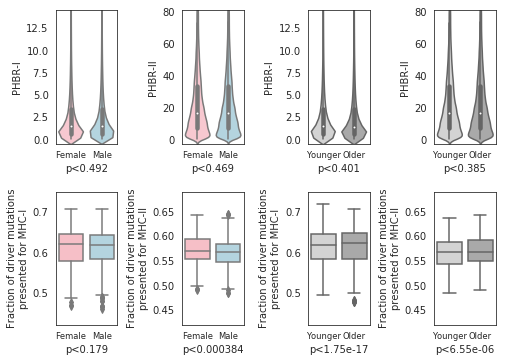

In [48]:
# plot again without homozygous patients
plt.figure(figsize=(7,5))

# A - All PHBR-I scores - sex
plt.subplot(2,4,1)
data = affinity_I_sex_df.join(confident_patients_I_rm_sex_specific[['sex']]).reset_index()
data = pd.melt(data, id_vars=['sex', 'index']).drop_duplicates()
data = data[~data.index.isin(homozygous_patients_I)]
p = mannwhitneyu(data[data['sex']=='female'].index.values, data[data['sex']=='male'].index.values).pvalue
sns.violinplot(x='sex', y='value', data=data, order=['female', 'male'], palette=['pink', 'lightblue'])
plt.xlabel('p<{:.3}'.format(p)), plt.ylabel('PHBR-I')
plt.xticks([0,1], ['Female', 'Male'], fontsize='small')
plt.ylim(ymin=-0.5, ymax=14.5)


# B - All PHBR-II scores - sex
plt.subplot(2,4,2)
data = affinity_II_sex_df.join(confident_patients_II_rm_sex_specific[['sex']]).reset_index()
data = pd.melt(data, id_vars=['sex', 'index']).drop_duplicates()
data = data[~data.index.isin(homozygous_patients_II)]
p = mannwhitneyu(data[data['sex']=='female'].index.values, data[data['sex']=='male'].index.values).pvalue
sns.violinplot(x='sex', y='value', data=data, order=['female', 'male'], palette=['pink', 'lightblue'])
plt.xlabel('p<{:.3}'.format(p)), plt.ylabel('PHBR-II')
plt.xticks([0,1], ['Female', 'Male'], fontsize='small')
plt.ylim(ymin=-2.7,ymax=81)


# C - All PHBR-I scores - age
plt.subplot(2,4,3)
data = affinity_I_age_df.join(confident_patients_I_kept_sex_specific[['age_categorical_3070']]).reset_index()
data = pd.melt(data, id_vars=['age_categorical_3070', 'index']).drop_duplicates()
data = data[~data.index.isin(homozygous_patients_I)]
p = mannwhitneyu(data[data['age_categorical_3070']=='younger'].index.values, data[data['age_categorical_3070']=='older'].index.values).pvalue
sns.violinplot(x='age_categorical_3070', y='value', data=data, order=['younger', 'older'], palette=['lightgrey', 'darkgrey'])
plt.xlabel('p<{:.3}'.format(p)), plt.ylabel('PHBR-I')
plt.xticks([0,1], ['Younger', 'Older'], fontsize='small')
plt.ylim(ymin=-0.5, ymax=14.5)


# D - All PHBR-II scores - age
plt.subplot(2,4,4)
data = affinity_II_age_df.join(confident_patients_II_kept_sex_specific[['age_categorical_3070']]).reset_index()
data = pd.melt(data, id_vars=['age_categorical_3070', 'index']).drop_duplicates()
data = data[~data.index.isin(homozygous_patients_II)]
p = mannwhitneyu(data[data['age_categorical_3070']=='younger'].index.values, data[data['age_categorical_3070']=='older'].index.values).pvalue
sns.violinplot(x='age_categorical_3070', y='value', data=data, order=['younger', 'older'], palette=['lightgrey', 'darkgrey'])
plt.xlabel('p<{:.3}'.format(p)), plt.ylabel('PHBR-II')
plt.xticks([0,1], ['Younger', 'Older'], fontsize='small')
plt.ylim(ymin=-2.7,ymax=81)

# E - Fraction PHBR-I presented - sex 
plt.subplot(2,4,5)
data = pd.DataFrame((affinity_I_sex_df < 2).sum(axis=1) / len(affinity_I_sex_df.columns), columns=['fraction'])
data = data.join(confident_patients_I_rm_sex_specific[['sex']])
data = data[~data.index.isin(homozygous_patients_I)]
p = mannwhitneyu(data[data['sex']=='female'].fraction.values, data[data['sex']=='male'].fraction.values).pvalue
sns.boxplot(x='sex', y='fraction', data=data, order=['female', 'male'], palette=['lightpink', 'lightblue'])
plt.xlabel('p<{:.3}'.format(p)), plt.ylabel('Fraction of driver mutations\npresented for MHC-I')
plt.xticks([0,1], ['Female', 'Male'], fontsize='small')
plt.ylim(ymin=0.42, ymax=0.75)

# F - Fraction PHBR-II presented - sex 
plt.subplot(2,4,6)
data = pd.DataFrame((affinity_II_sex_df < 20).sum(axis=1) / len(affinity_II_sex_df.columns), columns=['fraction'])
data = data.join(confident_patients_II_rm_sex_specific[['sex']])
data = data[~data.index.isin(homozygous_patients_II)]
p = mannwhitneyu(data[data['sex']=='female'].fraction.values, data[data['sex']=='male'].fraction.values).pvalue
sns.boxplot(x='sex', y='fraction', data=data, order=['female', 'male'], palette=['lightpink', 'lightblue'])
plt.xlabel('p<{:.3}'.format(p)), plt.ylabel('Fraction of driver mutations\npresented for MHC-II')
plt.xticks([0,1], ['Female', 'Male'], fontsize='small')
plt.ylim(ymin=0.42, ymax=0.69)

# G - Fraction PHBR-I presented - age
plt.subplot(2,4,7)
data = pd.DataFrame((affinity_I_age_df < 2).sum(axis=1) / len(affinity_I_age_df.columns), columns=['fraction'])
data = data.join(confident_patients_I_kept_sex_specific[['age_categorical_3070']])
data = data[~data.index.isin(homozygous_patients_I)]
p = mannwhitneyu(data[data['age_categorical_3070']=='younger'].index.values, data[data['age_categorical_3070']=='older'].index.values).pvalue
sns.boxplot(x='age_categorical_3070', y='fraction', data=data, order=['younger', 'older'], palette=['lightgrey', 'darkgrey'])
plt.xlabel('p<{:.3}'.format(p)), plt.ylabel('Fraction of driver mutations\npresented for MHC-I')
plt.xticks([0,1], ['Younger', 'Older'], fontsize='small')
plt.ylim(ymin=0.42, ymax=0.75)

# H - Fraction PHBR-II presented - age
plt.subplot(2,4,8)
data = pd.DataFrame((affinity_II_age_df < 20).sum(axis=1) / len(affinity_II_age_df.columns), columns=['fraction'])
data = data.join(confident_patients_II_kept_sex_specific[['age_categorical_3070']])
data = data[~data.index.isin(homozygous_patients_II)]
p = mannwhitneyu(data[data['age_categorical_3070']=='younger'].index.values, data[data['age_categorical_3070']=='older'].index.values).pvalue
sns.boxplot(x='age_categorical_3070', y='fraction', data=data, order=['younger', 'older'], palette=['lightgrey', 'darkgrey'])
plt.xlabel('p<{:.3}'.format(p)), plt.ylabel('Fraction of driver mutations\npresented for MHC-II')
plt.xticks([0,1], ['Younger', 'Older'], fontsize='small')
plt.ylim(ymin=0.42, ymax=0.69)

plt.tight_layout(pad=0.6, h_pad=1)

savepath = '/cellar/users/andreabc/Data/hla_sex/figures/supplementary/S2.sex_age_PHBR_fraction.{}.violin.no_homozygous.pdf'.format(MSS)
print('Saving to {}'.format(savepath))
plt.savefig(savepath)
plt.show()